# Simulation der Bildentstehung + Bildwiederherstellung
In diesem Notebook stellen wir künstlich ein Mikroskopbild aus simulierten Zellkernen, Rauschen und Hintergrund zusammen. Anschließend verwenden wir klassische Bildverarbeitungstechniken, um Rauschen und Hintergrund zu entfernen.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np

In [2]:
image_size = (100, 100)

# noise configuration
noise_level = 2

# background configuration
camera_offset = 100
background_sigma = 25
background_intensity = 5

# nuclei configuration
nuclei_radius = 5
nuclei_blur_sigma = 1
nuclei_number = 10
nuclei_intensity = 5

In [3]:
# by pinning the random seed, we can make the code repeatable
np.random.seed(42)

## Rauschen
Hier nehmen wir an, dass das Rauschen im Bild [Poisson-verteilt](https://de.wikipedia.org/wiki/Poisson-Verteilung) ist, eine häufige Annahme in der Mikroskopie.

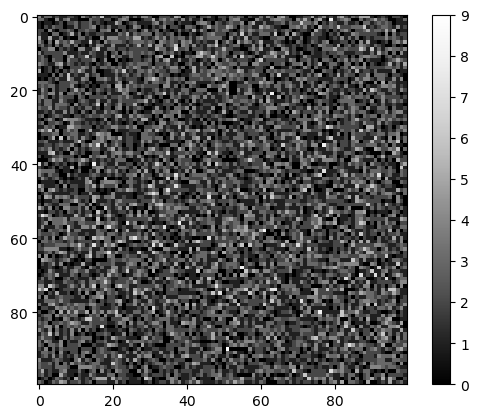

In [4]:
noise_image = np.random.poisson(noise_level, image_size)

cle.imshow(noise_image, colorbar=True)

## Hintergrund
Die Hintergrundintensität in Fluoreszenzmikroskopiebildern stammt typischerweise von unfokussiertem Licht. Wir können dies simulieren, indem wir Lichtquellen als einzelne Pixel platzieren und sie mit einem Gaußschen Filter verwischen. Darüber hinaus haben viele Mikroskopkameras einen sogenannten Kamera-Offset. Kein Pixel wird jemals eine Intensität unter diesem Wert haben.

cl.OCLArray([[102.02708 , 102.05994 , 102.09012 , ..., 100.354485, 100.342865,
        100.3312  ],
       [102.09299 , 102.12704 , 102.158325, ..., 100.38394 , 100.37136 ,
        100.358734],
       [102.1577  , 102.192924, 102.22533 , ..., 100.41521 , 100.4016  ,
        100.387955],
       ...,
       [100.162254, 100.17418 , 100.18678 , ..., 100.57553 , 100.55186 ,
        100.52856 ],
       [100.15136 , 100.16256 , 100.17441 , ..., 100.53596 , 100.51383 ,
        100.492065],
       [100.14104 , 100.15154 , 100.16266 , ..., 100.49834 , 100.477684,
        100.457375]], dtype=float32)
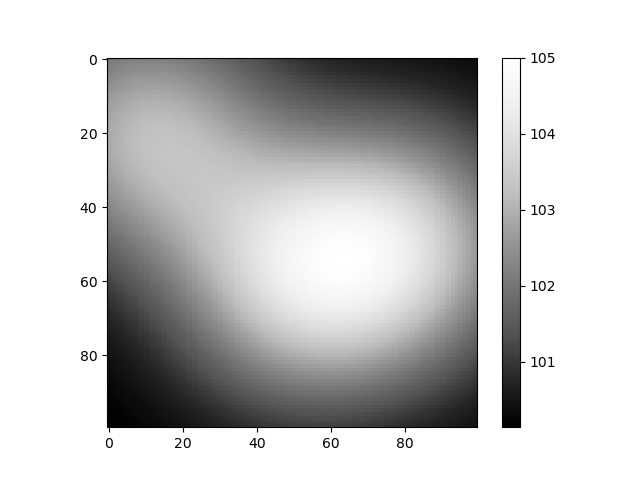
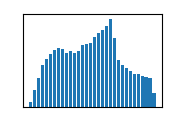

In [5]:
# create empty image
background = np.zeros(image_size)

# place light sources
background[20, 10] += 1
background[50, 80] += 1
background[60, 50] += 1

# blur them massively
background = cle.gaussian_blur(background, sigma_x=background_sigma, sigma_y=background_sigma)

# normalize the image so that the maximum intensity has a defined value
background = background / background.max() * background_intensity

# add camera offsert
background = background + camera_offset

background

## Zellkerne
Als nächstes platzieren wir Zellkerne in einem Bild an zufälligen Positionen. Wir verwischen sie ein wenig, um die [Punktspreizfunktion](https://de.wikipedia.org/wiki/Punktspreizfunktion) des Mikroskops zu simulieren.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
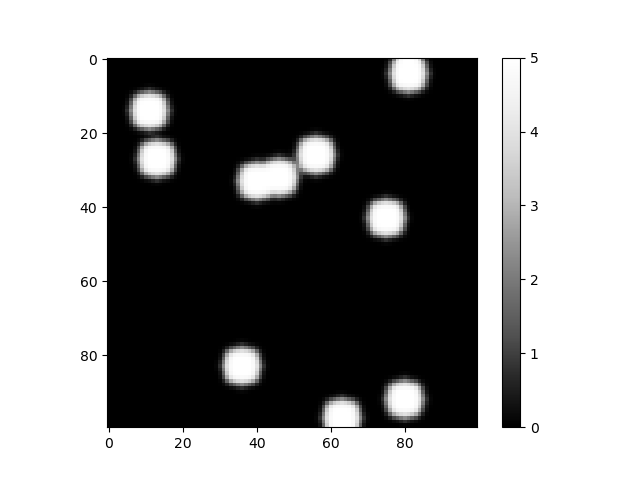
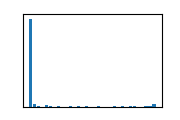

In [6]:
# retrieve a defined number of random positions
nuclei_positions = np.random.random((nuclei_number, 2)) * image_size

# write 1 at these locations
nuclei_image = cle.pointlist_to_labelled_spots(nuclei_positions.T, np.zeros(image_size))
nuclei_image = (nuclei_image > 0) * nuclei_intensity

# enlarge the nuclei by a define radius
nuclei_image = cle.maximum_sphere(nuclei_image, radius_x=nuclei_radius, radius_y=nuclei_radius)

# blur the image to make it look more realistic
nuclei_image = cle.gaussian_blur(nuclei_image, sigma_x=nuclei_blur_sigma, sigma_y=nuclei_blur_sigma)

nuclei_image

## Bildentstehung
Ein Mikroskopbild ist die Summe der Szene und der oben beschriebenen Effekte.

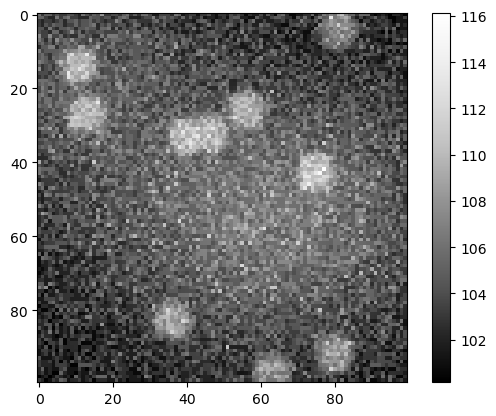

In [7]:
sum_image = np.asarray(noise_image + background + nuclei_image)

cle.imshow(sum_image, colorbar=True)

## Bildsegmentierung
Wenn wir jetzt einen Segmentierungsalgorithmus auf dieses Bild anwenden würden, wie es ist, könnte dies zu einem falschen Ergebnis führen.

cl.OCLArray([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
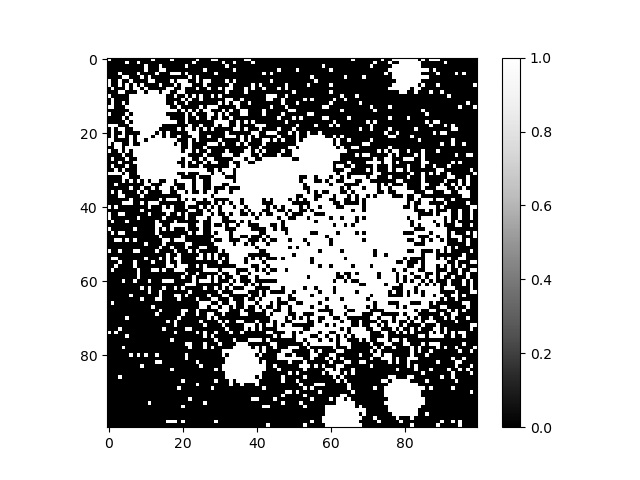
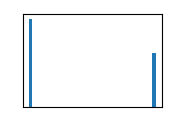

In [8]:
binary = cle.threshold_otsu(sum_image.astype(np.float32))

binary

## Hintergrundentfernung
Um dieses Problem zu beheben, müssen wir zuerst die Hintergrundintensität entfernen.

cl.OCLArray([[3.8403397 , 0.87319946, 2.9033813 , ..., 1.9769974 , 0.9653778 ,
        0.        ],
       [2.90625   , 2.9403    , 0.97158813, ..., 0.98750305, 0.9749222 ,
        2.9622955 ],
       [0.9647751 , 0.        , 0.94418335, ..., 0.98648834, 0.97288513,
        0.95923615],
       ...,
       [1.9481506 , 2.9600754 , 0.97267914, ..., 1.9328156 , 1.9091415 ,
        0.88584137],
       [0.        , 0.9756546 , 1.987503  , ..., 0.        , 0.        ,
        1.9782333 ],
       [2.9896774 , 1.988884  , 0.        , ..., 1.9623795 , 2.963852  ,
        0.9435425 ]], dtype=float32)
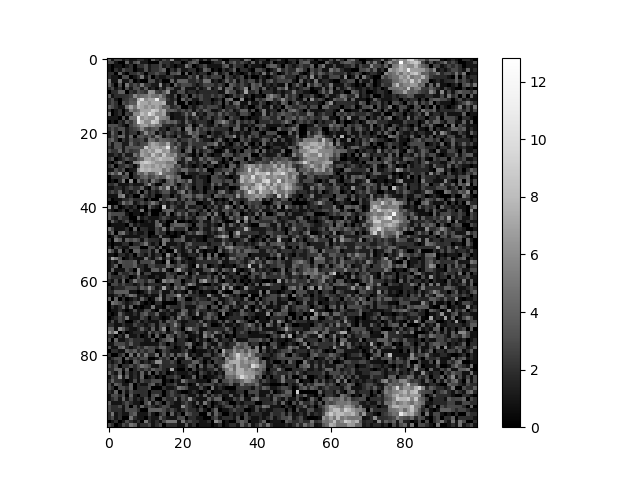
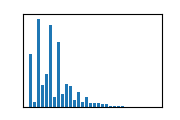

In [9]:
background_removed = cle.top_hat_box(sum_image, radius_x=10, radius_y=10)

background_removed

## Rauschentfernung
Wir können auch das Rauschen aus dem Bild entfernen.

cl.OCLArray([[104.74284 , 104.3482  , 104.095535, ..., 101.47704 , 101.363914,
        101.35629 ],
       [104.30064 , 104.044365, 103.93013 , ..., 101.66889 , 101.658714,
        101.65071 ],
       [104.04146 , 103.820206, 103.74111 , ..., 101.83249 , 101.82167 ,
        101.675224],
       ...,
       [102.205376, 101.97187 , 101.775345, ..., 102.33887 , 102.285355,
        101.99471 ],
       [101.98917 , 101.82425 , 101.76516 , ..., 102.513435, 102.288475,
        102.136536],
       [102.05105 , 101.98929 , 101.72292 , ..., 102.66122 , 102.23012 ,
        101.940834]], dtype=float32)
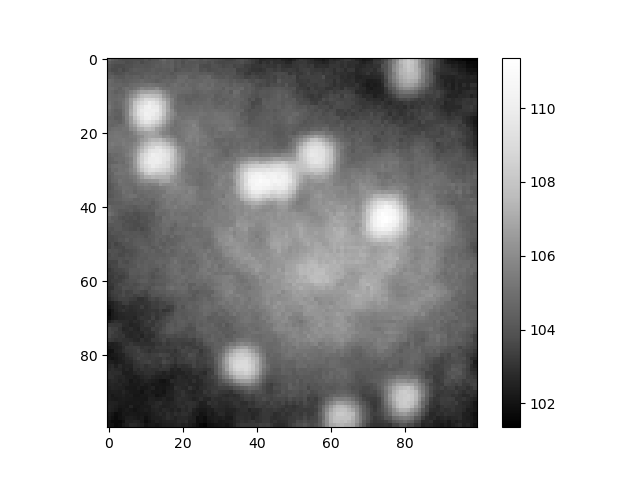
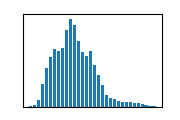

In [10]:
noise_removed1 = cle.mean_sphere(sum_image, radius_x=3, radius_y=3)

noise_removed1

Und dies kann auch auf dem hintergrundsubtrahierten Bild durchgeführt werden.

cl.OCLArray([[2.5495512, 2.1518824, 1.8934631, ..., 1.0838996, 0.9818381,
        0.9806079],
       [2.0891273, 1.8271031, 1.7071246, ..., 1.2431078, 1.249447 ,
        1.2490945],
       [1.7942544, 1.5672424, 1.4824032, ..., 1.3784474, 1.3799691,
        1.2459035],
       ...,
       [1.9805651, 1.7442198, 1.5428588, ..., 1.6989396, 1.6650388,
        1.3941103],
       [1.7917184, 1.6217978, 1.5557053, ..., 1.914941 , 1.7043592,
        1.5668714],
       [1.8778669, 1.8098779, 1.5343451, ..., 2.0801234, 1.6664302,
        1.393364 ]], dtype=float32)
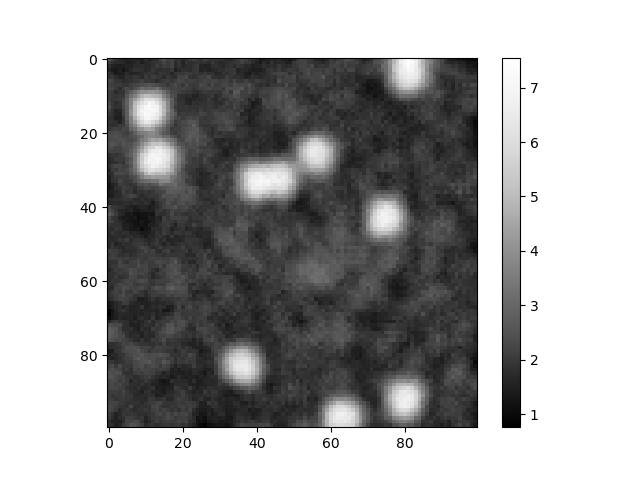
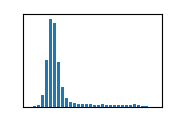

In [11]:
noise_removed = cle.mean_sphere(background_removed, radius_x=3, radius_y=3)

noise_removed

## Bildsegmentierung II
Nach der Korrektur des Bildes können wir die Segmentierung erneut versuchen.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
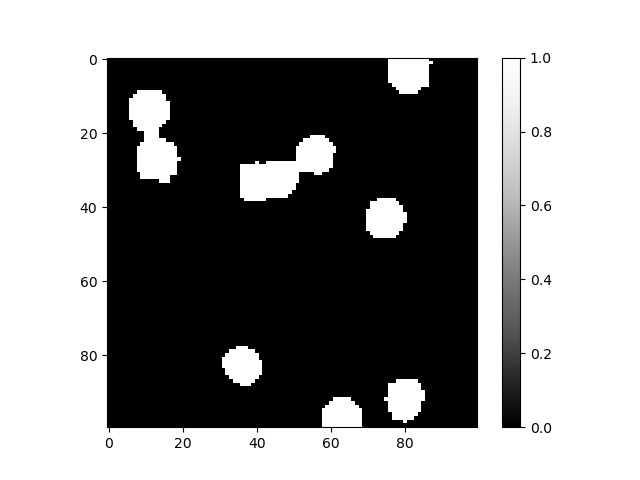
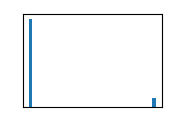

In [12]:
binary2 = cle.threshold_otsu(noise_removed.astype(np.float32))

binary2

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
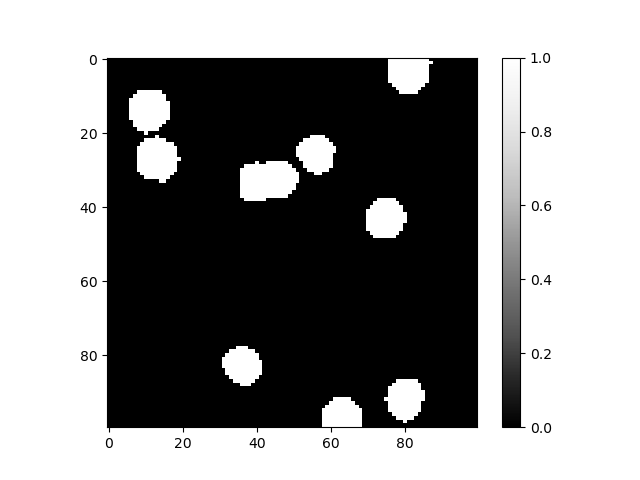
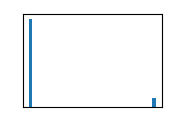

In [13]:
# sneak preview: watershed
import napari_segment_blobs_and_things_with_membranes as nsbatwm
binary3 = nsbatwm.split_touching_objects(binary2)

binary3